[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.2808 - loss: 1.3556 - val_accuracy: 0.6656 - val_loss: 0.7887 - learning_rate: 0.0010
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7042 - loss: 0.7038 - val_accuracy: 0.8742 - val_loss: 0.3746 - learning_rate: 0.0010
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8780 - loss: 0.3671 - val_accuracy: 0.8854 - val_loss: 0.3137 - learning_rate: 0.0010
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8887 - loss: 0.3016 - val_accuracy: 0.8742 - val_loss: 0.3207 - learning_rate: 0.0010
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9027 - loss: 0.2655 - val_accuracy: 0.8806 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9061 - loss: 0.2419 - val_accuracy: 0.8869 - val_loss: 0.2738 - learning_rate: 5.0000e-04
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9059 - loss: 0.2170 - val_ac

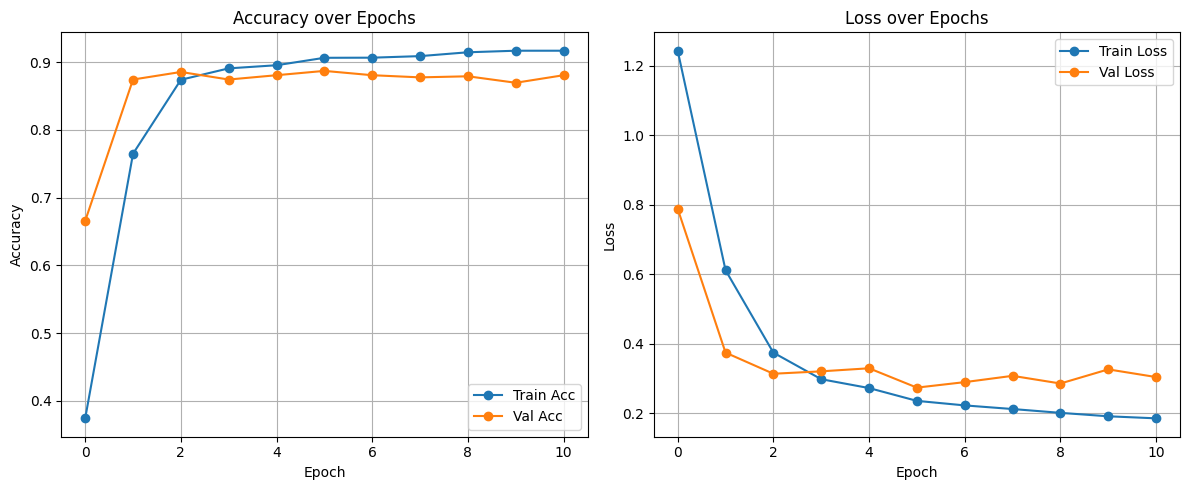

In [24]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import nltk
from nltk.corpus import wordnet

# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load dataset
df = pd.read_excel('/kaggle/input/onubad/Sentence.xlsx')

# Text cleaning
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Augmentation methods
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    candidates = [w for w in words if wordnet.synsets(w)]
    random.shuffle(candidates)
    for w in candidates[:n]:
        syns = wordnet.synsets(w)
        if syns:
            lemma = syns[0].lemmas()[0].name()
            new_words = [lemma if t == w else t for t in new_words]
    return ' '.join(new_words)

def random_deletion(sentence, p=0.1):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    kept = [w for w in words if random.random() > p]
    return ' '.join(kept) if kept else random.choice(words)

def augment_text(text):
    return random.choice([synonym_replacement, random_deletion])(text)

# Build dialect-labeled dataset (with augmentation)
data = []
for _, row in df.iterrows():
    for dialect, col in [
        ('Chittagong', 'Chittagong Language'),
        ('Sylhet',    'Sylhet Language'),
        ('Barisal',   'Barisal Language'),
        ('Standard',  'Standard Bangla Lanuguage')
    ]:
        sent = clean_text(row[col])
        data.append({'text': sent, 'dialect': dialect})
        data.append({'text': augment_text(sent), 'dialect': dialect})

dialect_df = pd.DataFrame(data)

# Encode labels
y = pd.get_dummies(dialect_df['dialect']).values
dialect_columns = pd.get_dummies(dialect_df['dialect']).columns

# Tokenize & pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dialect_df['text'])
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(dialect_df['text'])
max_len = max(len(s) for s in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build the model (reduced complexity, no L2, no batch norm)
embedding_dim = 50
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dropout(0.5),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(len(dialect_columns), activation='softmax')
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, lr_scheduler]
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Prediction helper
def predict_dialect(text):
    txt = clean_text(text)
    seq = tokenizer.texts_to_sequences([txt])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad, verbose=0)
    return dialect_columns[np.argmax(pred)]

# Example prediction
test_sentence = "আমি ইক্কে নযাইয়ুম"
print(f"\nSentence: {test_sentence}")
print(f"Predicted Dialect: {predict_dialect(test_sentence)}")

# Plot accuracy & loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import classification_report
import numpy as np

# Predict probabilities on the test set
y_pred_prob = model.predict(X_test, verbose=0)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=dialect_columns
)

# Print the report
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

     Barisal       0.84      0.91      0.88       381
  Chittagong       0.98      0.91      0.95       400
    Standard       0.87      0.83      0.85       397
      Sylhet       0.83      0.86      0.84       390

    accuracy                           0.88      1568
   macro avg       0.88      0.88      0.88      1568
weighted avg       0.88      0.88      0.88      1568



In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")



Test Accuracy: 87.82%


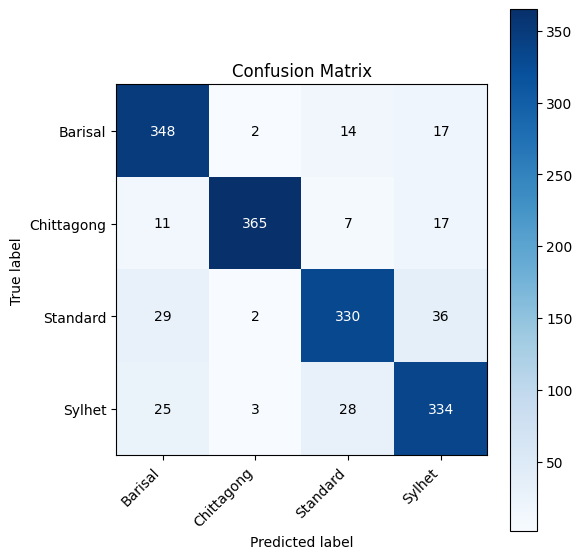

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Tick marks and labels
classes = dialect_columns
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticklabels(classes)

# Labels and title
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Confusion Matrix')

# Annotate each cell with counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3761 - loss: 1.4540 - val_accuracy: 0.2404 - val_loss: 1.3550 - learning_rate: 0.0010
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8126 - loss: 0.5697 - val_accuracy: 0.4236 - val_loss: 1.1904 - learning_rate: 0.0010
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8693 - loss: 0.3977 - val_accuracy: 0.7420 - val_loss: 0.6403 - learning_rate: 0.0010
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8907 - loss: 0.3442 - val_accuracy: 0.8694 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8880 - loss: 0.3264 - val_accuracy: 0.8694 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8890 - loss: 0.3140 - val_accuracy: 0.8519 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8972 - loss: 0.2757 - val

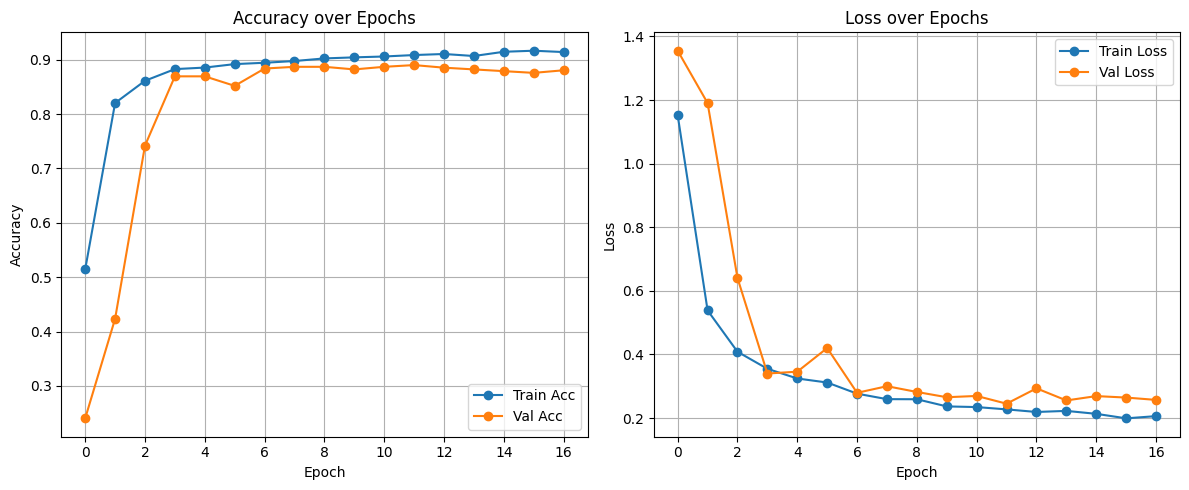

In [29]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout,
    Bidirectional, LeakyReLU, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import nltk
from nltk.corpus import wordnet

# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load dataset
df = pd.read_excel('/kaggle/input/onubad/Sentence.xlsx')

# Text cleaning
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Augmentation methods
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    candidates = [w for w in words if wordnet.synsets(w)]
    random.shuffle(candidates)
    for w in candidates[:n]:
        syns = wordnet.synsets(w)
        if syns:
            lemma = syns[0].lemmas()[0].name()
            new_words = [lemma if t == w else t for t in new_words]
    return ' '.join(new_words)

def random_deletion(sentence, p=0.1):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    kept = [w for w in words if random.random() > p]
    return ' '.join(kept) if kept else random.choice(words)

def augment_text(text):
    return random.choice([synonym_replacement, random_deletion])(text)

# Build dialect-labeled dataset (with augmentation)
data = []
for _, row in df.iterrows():
    for dialect, col in [
        ('Chittagong', 'Chittagong Language'),
        ('Sylhet',    'Sylhet Language'),
        ('Barisal',   'Barisal Language'),
        ('Standard',  'Standard Bangla Lanuguage')
    ]:
        sent = clean_text(row[col])
        data.append({'text': sent, 'dialect': dialect})
        data.append({'text': augment_text(sent), 'dialect': dialect})

dialect_df = pd.DataFrame(data)

# Encode labels
y = pd.get_dummies(dialect_df['dialect']).values
dialect_columns = pd.get_dummies(dialect_df['dialect']).columns

# Tokenize & pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dialect_df['text'])
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(dialect_df['text'])
max_len = max(len(s) for s in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build the model with Batch Normalization
embedding_dim = 50
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),

    Bidirectional(LSTM(32, return_sequences=True)),
    BatchNormalization(),

    Bidirectional(GRU(32)),
    BatchNormalization(),

    Dropout(0.3),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dropout(0.5),
    Dense(len(dialect_columns), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, lr_scheduler]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Prediction function
def predict_dialect(text):
    txt = clean_text(text)
    seq = tokenizer.texts_to_sequences([txt])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad, verbose=0)
    return dialect_columns[np.argmax(pred)]

# Example prediction
test_sentence = "আমি ইক্কে নযাইয়ুম"
print(f"\nSentence: {test_sentence}")
print(f"Predicted Dialect: {predict_dialect(test_sentence)}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout,
    Bidirectional, BatchNormalization, Activation
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import nltk
from nltk.corpus import wordnet

# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load dataset
df = pd.read_excel('/kaggle/input/onubad/Sentence.xlsx')

# Text cleaning
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Augmentation methods
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    candidates = [w for w in words if wordnet.synsets(w)]
    random.shuffle(candidates)
    for w in candidates[:n]:
        syns = wordnet.synsets(w)
        if syns:
            lemma = syns[0].lemmas()[0].name()
            new_words = [lemma if t == w else t for t in new_words]
    return ' '.join(new_words)

def random_deletion(sentence, p=0.1):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    kept = [w for w in words if random.random() > p]
    return ' '.join(kept) if kept else random.choice(words)

def augment_text(text):
    return random.choice([synonym_replacement, random_deletion])(text)

# Build dialect‑labeled dataset (with augmentation)
data = []
for _, row in df.iterrows():
    for dialect, col in [
        ('Chittagong', 'Chittagong Language'),
        ('Sylhet',    'Sylhet Language'),
        ('Barisal',   'Barisal Language'),
        ('Standard',  'Standard Bangla Lanuguage')
    ]:
        sent = clean_text(row[col])
        data.append({'text': sent, 'dialect': dialect})
        data.append({'text': augment_text(sent), 'dialect': dialect})

dialect_df = pd.DataFrame(data)

# Encode labels
y = pd.get_dummies(dialect_df['dialect']).values
dialect_columns = pd.get_dummies(dialect_df['dialect']).columns

# Tokenize & pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dialect_df['text'])
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(dialect_df['text'])
max_len = max(len(s) for s in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Train‑test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build the model with ReLU activation
embedding_dim = 50
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),

    Bidirectional(LSTM(32, return_sequences=True)),
    BatchNormalization(),

    Bidirectional(GRU(32)),
    BatchNormalization(),

    Dropout(0.3),

    Dense(32),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.5),
    Dense(len(dialect_columns), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    # callbacks=[early_stop, lr_scheduler]
)



2025-04-27 11:08:52.581151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745752132.777327      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745752132.831888      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1745752148.995990      31 gpu_device.cc:2022] Created device /job:localhos

Epoch 1/50


I0000 00:00:1745752158.238187      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.2759 - loss: 1.6711 - val_accuracy: 0.2404 - val_loss: 1.3861
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3664 - loss: 1.4087 - val_accuracy: 0.2420 - val_loss: 1.3619
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4423 - loss: 1.2077 - val_accuracy: 0.4331 - val_loss: 1.2091
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5373 - loss: 1.0410 - val_accuracy: 0.7197 - val_loss: 0.8819
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6514 - loss: 0.8689 - val_accuracy: 0.7834 - val_loss: 0.7025
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6935 - loss: 0.7886 - val_accuracy: 0.8041 - val_loss: 0.6062
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7534 - loss: 0.6820 - val_accuracy: 0.8360 - val_loss: 0.5237
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7823 - loss: 0.6240 - val_accuracy: 0.86

In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 11, 50)              │          72,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 11, 64)              │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 345,460 (1.32 MB)

 Trainable params: 115,046 (449.40 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 230,094 (898.81 KB)

In [3]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Prediction function
def predict_dialect(text):
    txt = clean_text(text)
    seq = tokenizer.texts_to_sequences([txt])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad, verbose=0)
    return dialect_columns[np.argmax(pred)]

# Example prediction
test_sentence = "আমি ইক্কে নযাইয়ুম"
print(f"\nSentence: {test_sentence}")
print(f"Predicted Dialect: {predict_dialect(test_sentence)}")


Test Accuracy: 86.67%

Sentence: আমি ইক্কে নযাইয়ুম
Predicted Dialect: Chittagong


In [5]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels (y_test) to a 1D array of class indices
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=dialect_columns)
print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

     Barisal       0.77      0.93      0.84       381
  Chittagong       0.96      0.93      0.95       400
    Standard       0.88      0.79      0.83       397
      Sylhet       0.88      0.82      0.85       390

    accuracy                           0.87      1568
   macro avg       0.87      0.87      0.87      1568
weighted avg       0.87      0.87      0.87      1568



In [4]:
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np

# Get model predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=dialect_columns, output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Display the report
print(report_df)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score      support
Barisal        0.767896  0.929134  0.840855   381.000000
Chittagong     0.963636  0.927500  0.945223   400.000000
Standard       0.879552  0.790932  0.832891   397.000000
Sylhet         0.876712  0.820513  0.847682   390.000000
accuracy       0.866709  0.866709  0.866709     0.866709
macro avg      0.871949  0.867020  0.866663  1568.000000
weighted avg   0.873165  0.866709  0.867161  1568.000000


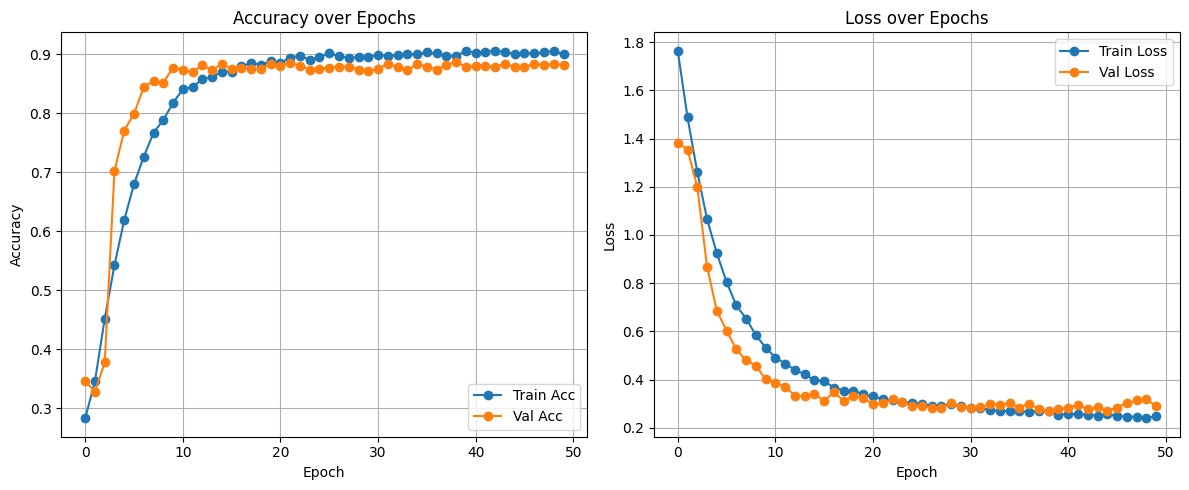

In [5]:

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
# Plot training accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_plot.png', dpi=500)
plt.close()

# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_plot.png', dpi=500)
plt.close()


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities and classes
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices
y_true = np.argmax(y_test, axis=1)  # True class indices

# ----------- Confusion Matrix (Save) -----------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dialect_columns)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('')  # Remove title
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.close()

# ----------- ROC-AUC Curve (Save) -----------
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(dialect_columns)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i, label in enumerate(dialect_columns):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('auc_roc_curve.png', dpi=300)
plt.close()


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# ----------- Precision-Recall Curve (Save) -----------
precision = {}
recall = {}
average_precision = {}

plt.figure(figsize=(6, 5))

for i, label in enumerate(dialect_columns):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], label=f'{label} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300)
plt.close()


/tmp/ipykernel_31/3908666206.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, cmap='viridis')
/tmp/ipykernel_31/3908666206.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, cmap='viridis')


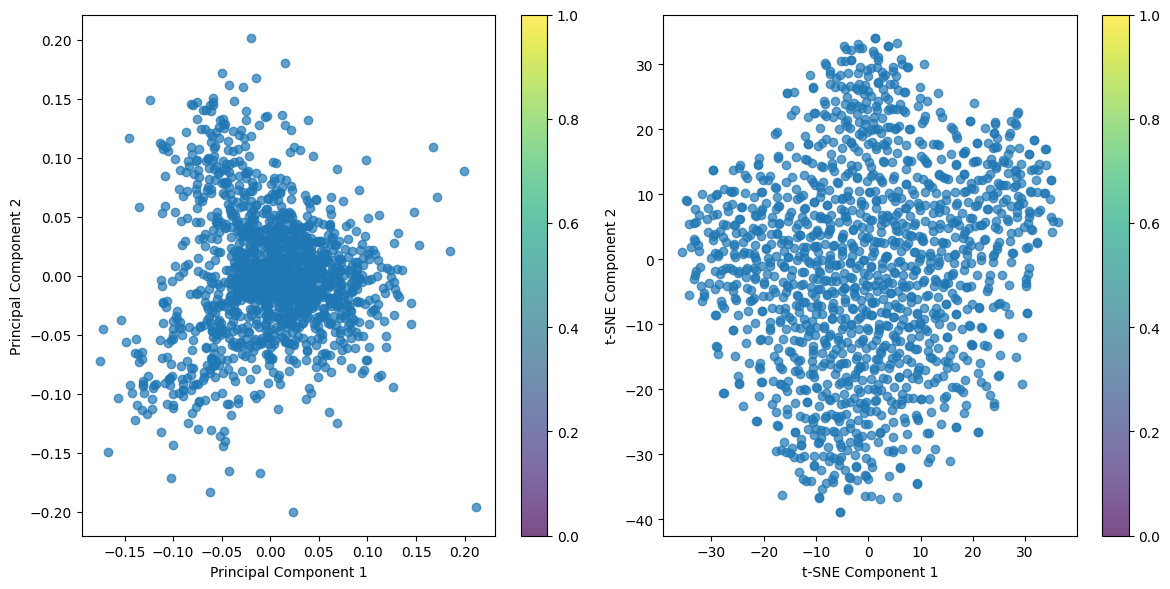

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get the embeddings from the trained model (after the embedding layer)
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embedding_weights)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embedding_weights)

# Plot PCA and t-SNE visualizations
plt.figure(figsize=(12, 6))

# PCA Plot
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, cmap='viridis')
plt.title("")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()

# t-SNE Plot
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, cmap='viridis')
plt.title("")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar()

# Save the plots with high DPI
plt.tight_layout()
plt.savefig("pca_embedding_visualization.png", dpi=300)
plt.savefig("tsne_embedding_visualization.png", dpi=300)

# Show the plots
plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


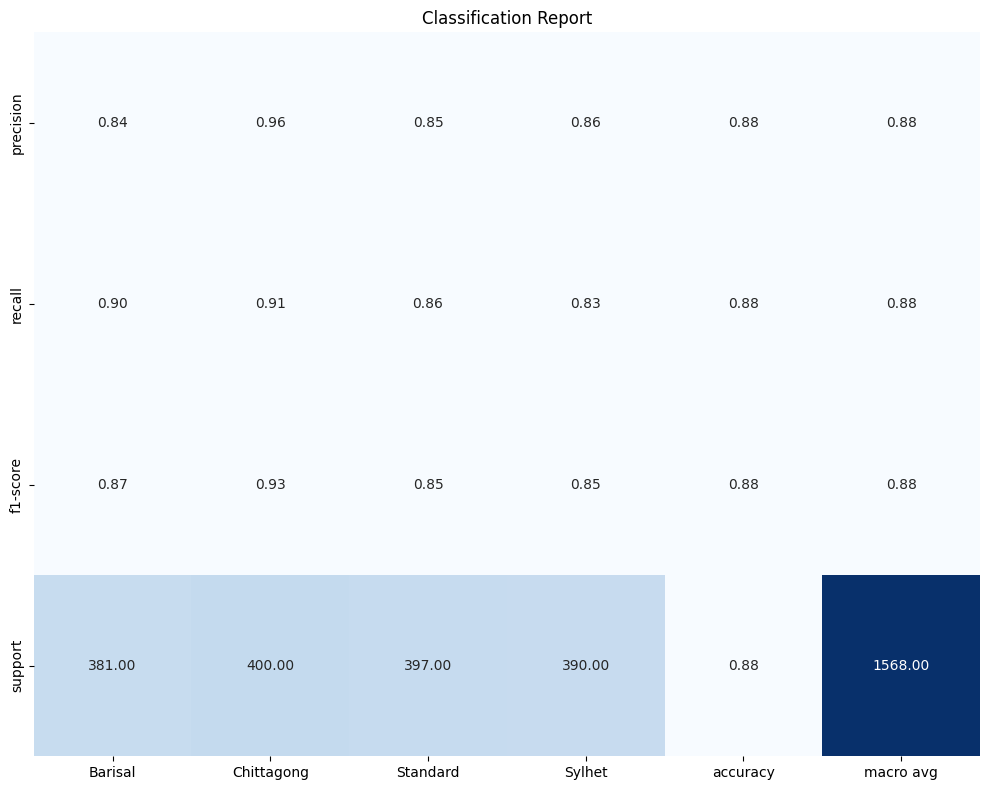

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np

# Get model predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=dialect_columns, output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Classification Report')
plt.tight_layout()

# Save the plot as a figure
plt.savefig('classification_report_figure.png', dpi=300)

# Show the plot
plt.show()
